# Point Set Registration

In [1]:
# Required Packages
using LinearAlgebra
using Plots

## The Problem 



Given two corresponding point patterns $X$ and $Y$, we want to find a similarity transformation $T$, given by Rotation matrix $R$, scale factor $c$ and translational vector $t$, that aligns the points in correspondency, in the best way possible. In other words, $$\hat{X}=T_{R,c,t}(X)\approx Y$$

In this case "the best way possible" means minimizing the mean square error. We are going to implement an algorithm, derived from [1], applied to different geometric figures. 

## The Algorithm

### Definitions 

We define the $\textbf{mean vector}$ of each set $X$ and $Y$ as
\begin{align}
\mu_x &= \frac{1}{n}\sum_{i=1}^n x_i \\
\mu_y &= \frac{1}{n}\sum_{i=1}^n y_i
\end{align}

The following are called $\textbf{the variances}$ around the mean vectors of the point sets
\begin{align}
\sigma_x^2 &= \frac{1}{n}\sum_{i=1}^{n}\lvert \lvert x_i - \mu_x \lvert \lvert ^2 \\
\sigma_y^2 &= \frac{1}{n}\sum_{i=1}^{n}\lvert \lvert y_i - \mu_y \lvert \lvert ^2
\end{align}

Finally, the $\textbf{variance-covariance matrix}$ between the two point patterns $X$ and $Y$ is given by: 
$$\Sigma_{xy} = \frac{1}{n} \sum_{i=1}^n (y_i-\mu_y)(x_i-\mu_x)^T $$

### The Minimum Mean Squared Error 

According to [1], given $X=\{x_i\}_{i=1}^n$ and $Y=\{y_i\}_{i=1}^n$ correspondent point patterns in a m-dimensional space, the  minimum value of mean squared error $$e^2(R,t,c)=\frac{1}{n}\sum_{i=1}^n\lvert\lvert y_i - cRx_i+t \lvert\lvert^2$$
Is given by 

$$\epsilon = \sigma^2_y - \frac{tr(DS)^2}{\sigma^2_x}$$

Where $\sigma^2_x$ and $\sigma^2_y$ are the variances of $X$ and $Y$ respectively and $D$,$S$ are certain matrices we are defining in the next subsection.

### Minimization Arguments

The minization arguments $R$,$c$ and $t$ can be obtained applying the following algorithm:

$\textbf{1.}$ Compute the variance-covariance matrix between $X$ and $Y$, given by: 
$$\Sigma_{xy}=\frac{1}{n}\sum_{i=1}^n(y_i-\mu_y)(x_i-\mu_x)^T$$
This is a positive semidefinite matrix.



$\textbf{2.}$ Calculate the singular value decomposition of covariance matrix $$\Sigma_{xy} = UDV^T$$
Where
- $D$ is a diagonal matrix consisting of non-negative singular values of $\Sigma_{xy}$
- $U,V$ are orthogonal real matrices.



$\textbf{3.}$ Calculate $S$ matrix considering the restriccions as:
- If $\text{rank}(\Sigma_{xy})>m-1$, then $S$ is given by 

$$ S = \left\{ 
\begin{array}{ll}
I &\text{if } \det{\left(\Sigma_{xy}\right)}\geq 0 \\
diag(1,1,...,-1) &\text{if } \det{\left(\Sigma_{xy}\right)<0} 
\end{array}
\right. $$

- If $\text{rank}(\Sigma_{xy})=m-1$, then $S$ is given by

$$ S = \left\{ 
\begin{array}{ll}
I &\text{if } \det{(U)}\det{(V)}= 1 \\
diag(1,1,...,-1) &\text{if }\det{(U)}\det{(V)}= -1 
\end{array}
\right. $$





$\textbf{4.}$ Compute the arguments or parameters $R,c$ and $t$ as:

\begin{align}
R &= USV^T \\
c &= \frac{1}{\sigma^2_x}\textbf{tr}{(DS)} \\
t &= \mu_y - cR\mu_x
\end{align} 

In the next code cell we are defining a function to apply the algorithm described above, it takes the point sets $X$ and $Y$ as input and returns the optimal transformation parameters $R,c$ and $t$. It also has a third argument which could be true or false, if it's true, the function also returns the error $\epsilon^2$ calculated with Umeya's formula

In [2]:
### Algortihm to calculate optimum transform parameters ###

function Transformation_Parameters(X,Y,compute_error)
    
    # Useful constant
    n = size(X,1)
    
    # Compute mean vectors
    μ_x = 1/n * [ sum(X[:,1]) ; sum(X[:,2])]; 
    μ_y = 1/n * [ sum(Y[:,1]) ; sum(Y[:,2])];
    
    # Compute variance around mean vectors
    σ_x = 1/n *sum([(X[i,:]-μ_x)'*(X[i,:]-μ_x) for i in 1:n]);
    σ_y = 1/n * sum([(Y[i,:]-μ_y)'*(Y[i,:]-μ_y) for i in 1:n]);
    
    # Calculate covariance matrix between X and Y 
    Σ = 1/n * sum([ (Y[i,:]-μ_y)*(X[i,:]-μ_x)' for i in 1:n]);
   
    #Singular values decomposition
    U , D , V = svd(Σ);
    
    # NOTE 1: When we use svd function of LinearAlgebra Package, it returns D as a column vector. 
    #         So it is necessary to turn D in a diagonal matrix.
    D = diagm(D)
    # Now we save the number of singular values. It depends on the dimension m of the space where we are working
    m = size(D,1);
    
    # Computing S according to the restrictions
    if rank(Σ) >= m - 1
        if det(Σ)>=0
            S = 1*I(m); 
        elseif det(Σ)<0
            S = 1*I(m);
            S[m,m] = -1;
        end

    elseif rank(Σ) == m - 1
        if det(U)*det(V) == 1 
            S = 1*I(m);
        elseif det(U)*det(V) == -1 
            S = 1*I(m);
            S[m,m] = -1;
        end
    end

    
    # Compute transform parameters
    R = U*S*V
    c = 1/σ_x * tr(D*S)
    t = μ_y - c*R*μ_x
    
    # Calculate error given by Umeya's Formula if the user wants to
    if compute_error == true
        ϵ = σ_y - tr(D*S)^2 / σ_x
        return R,c,t,ϵ
    else 
        
    return R,c,t
        
    end
    
end

Transformation_Parameters (generic function with 1 method)

## Graphic Animation

In this section we create a function to see the transformation with an animation. The $Y$ points are static and we set an $\textbf{animation parameter i}$ . We also create a set of points $Z$ such that: 
<center>When $i=0$ then $Z=X$ and when $i=1$ then $Z=\hat{X}$ </center>

Where $\hat{X}$ correspond to the set of points $X$ under the transformation given the parameters $R,c,t$.

In the first place, we know that for each $x_i\in X$ it's transformation is given by: 
$$\hat{x}_i = cRx_i + t$$

Consider $t = [t_1 \hspace{0.3cm}t_2]'$. Define de follwing matrix.
$$T_{n\times 2} = \begin{bmatrix}
t_1 & t_2 \\
t_1 & t_2 \\
\vdots & \vdots \\
t_1 & t_2
\end{bmatrix}$$

Then we can get the tranformation of the whole point set with the vectorial equation: 
$$\hat{X}= cXR' + T$$

Considering the animation parameter $i$, if we define $Z$ as 

$$ Z = (1+(c-1)i) X + i T $$

Clearly when $i=0$, then $Z=X$ and when $i=1$ then $Z=cX+T$ which means that $Z$ reach the scale and translation desirables. 

Now we ought to handle with the rotation parameter. We know that $R$ is a rotation matrix, so it has an $\beta$ angle associated. So the angle for the animation should be $0$ when $i=0$ and $\beta$ when $i=1$. Let $M(\theta)$ denote the rotation matrix associated to $\theta$ angle. So, finally we can parametrize by $i$ the transformation of $Z$ with the expression.

$$ Z(i) = (1+(c-1)i)* X * (M(i\beta))' + i T $$

In the next code cell we define a function to make the animation

In [3]:
function Animate(X,Y,R,c,t)
    
    # Useful constants
    n = size(X,1)
    m = size(t,1)
    
    # Building T
    T = ones(n,m)*diagm(t)
    
    # Getting the angle associated to the rotation matrix R.
    β = atan(R[2,1],R[1,1])
    
    # Gif animation 
    @gif for i in range(0,1,100)

            # Build the variable rotation matrix
            M = Array([cos(i*β) -sin(i*β) ; sin(i*β) cos(i*β) ])
            # Define Z
            Z = (1+(c-1)*i) * X * M' + i*T
            
            # Ploting Variable points Z
            scatter(Z[:,1],Z[:,2], color="darkblue", label="T(X)")
            # Ploting static points Y
            scatter!(Y[:,1],Y[:,2], color="red", label="Y")
            
            # Set static plane based on the dimensions of the figure determined by Y and adding a 80% margin
            xlims!((1.8*minimum(Y[:,1]),1.8*maximum(Y[:,1])))
            ylims!((1.8*minimum(Y[:,2]),1.8*maximum(Y[:,2])))
            
         end
end

Animate (generic function with 1 method)

## Implementation

The next function is useful to make deformations to the figures. It takes a set of points describing a figure and rotates them given an $\theta$ angle 

In [4]:
# Rotate a point set i.e a figure
function Rotate(X,θ)
    Rot = Array([cos(θ) -sin(θ) ; sin(θ) cos(θ)])
    X = X*Rot'
    return X
end

Rotate (generic function with 1 method)

### Polar Rose

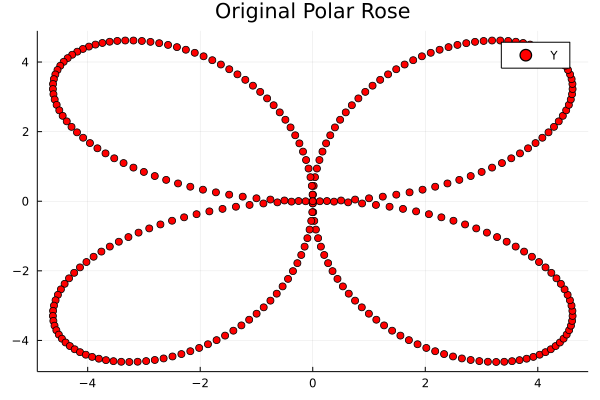

In [5]:
# Parametrization of the Polar Rose with 500 points
n = 300
t = LinRange(0 , 2π , n )
PR_y_1 = 3*sin.(t) + 3*sin.(3*t);
PR_y_2 = 3cos.(t) - 3*cos.(3t);
PR_Y = [PR_y_1 PR_y_2];
scatter(PR_Y[:,1],PR_Y[:,2], title="Original Polar Rose", color="red", label="Y")

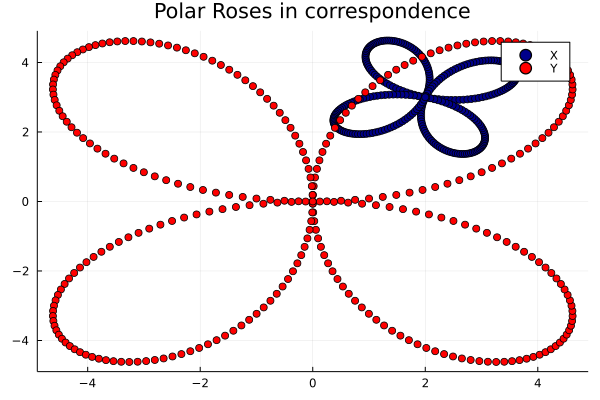

In [6]:
# Deforming the Polar Rose 

# Reescale
PR_X = 0.3*PR_Y
# Rotate 
PR_X = Rotate(PR_X,π\4)
# Translate 2 units in the x-axes and 3 in the y-axes
a,b = 2,3
PR_X[:,1] = PR_X[:,1]+a*ones(n)
PR_X[:,2] = PR_X[:,2]+b*ones(n)


scatter(PR_X[:,1],PR_X[:,2], title="Polar Roses in correspondence", color="darkblue", label="X")
scatter!(PR_Y[:,1],PR_Y[:,2], color="red", label="Y")

In [7]:
### Apply the algorithm to get the optimum transformation parameters and the error. ###

R,c,t,ϵ = Transformation_Parameters(PR_X,PR_Y,true);
print("The mean square error is: ", ϵ)

The mean square error is: -3.552713678800501e-15

┌ Info: Saved animation to 
│   fn = C:\Users\JSeba\Documents\UNAL\MathML\Homework1\tmp.gif
└ @ Plots C:\Users\JSeba\.julia\packages\Plots\8K4be\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\JSeba\\Documents\\UNAL\\MathML\\Homework1\\tmp.gif")
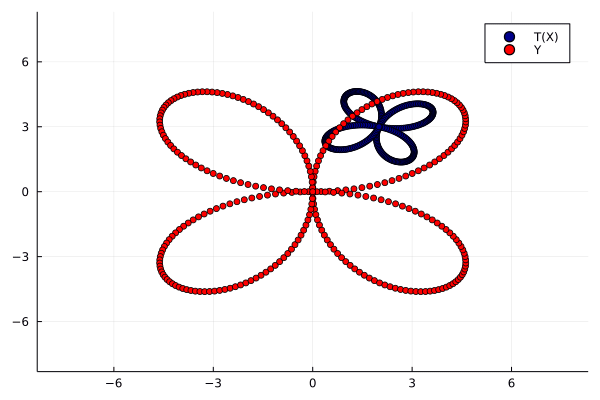

In [8]:
Animate(PR_X,PR_Y,R,c,t)

### Heart

In [9]:
# Parametrization of a heart with 300 points
k = 300
r = LinRange(0 , 2π , k )
H_y_1 = 16*(sin.(r)).^3;
H_y_2 = 13*cos.(r)-5*cos.(2*r)-2*cos.(3*r)-cos.(4r)
H_Y = [H_y_1 H_y_2]

# Creating X point set
# Reescaling
H_X = 1.5*H_Y
#Rotating
H_X = Rotate(H_X,π\4)
# Translating
H_X[:,1] = H_X[:,1]+0.4*ones(k);
H_X[:,2] = H_X[:,2]-2*ones(k);

┌ Info: Saved animation to 
│   fn = C:\Users\JSeba\Documents\UNAL\MathML\Homework1\tmp.gif
└ @ Plots C:\Users\JSeba\.julia\packages\Plots\8K4be\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\JSeba\\Documents\\UNAL\\MathML\\Homework1\\tmp.gif")
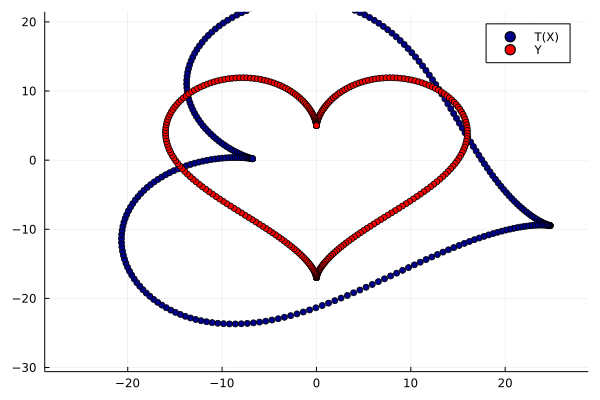

In [10]:
# Apply the algorithm
R,c,t = Transformation_Parameters(H_X,H_Y,false)
# Showing the animation
Animate(H_X,H_Y,R,c,t)

## Bibliography

[1] S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991